# Support Vector Machine

1. Take the ‘geyser.csv’ for the classification task. 

Split it on train and test parts. 
Train the [Linear Regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) on it. To do it, you should convert labels to numbers, where a positive class (P) will be encoded by ‘+1’, and a negative (N) by ‘-1’. Cast linear regression predictions backward to labels. Compare them with real labels and print F1 score. Print the resulting equation of the line.

2. Consider ‘chips.csv’. 

Also split it on train and test parts.
For both datasets, train and test the [SVM model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) on them. Try different kernels. For each kernel, find the best parameters for it and draw how the SVM model classify whole space with it. You can find an example [here](https://colab.research.google.com/drive/1G9pHzipwykMJZbQP8NgJF5bWaSTPlOmJ) (notebook in the attachment).
Compare the SVM results (by F1 score) with the Linear Regression.

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, make_scorer, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
test_size = .3

# Datasets

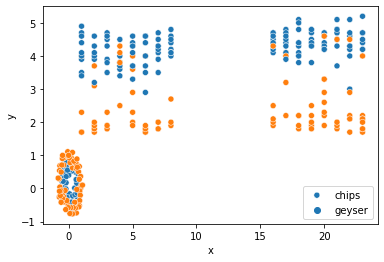

In [3]:
df1 = pd.read_csv("chips.csv", sep=',')
df2 = pd.read_csv("geyser.csv", sep=',')

sns.scatterplot(x='x',y='y',data=df1,hue='class',color='blue')
sns.scatterplot(x='x',y='y',data=df2,hue='class',color='green')

plt.legend(labels=['chips', 'geyser'])

# Data preparation

In [4]:
# prepare data: convert, split
def prepare_data(df):
    df.loc[df['class'] == 'P', 'class'] = 1
    df.loc[df['class'] == 'N', 'class'] = -1

    X = df.loc[:, ~df.columns.isin(['class'])].values
    y = df['class'].values
    
    X = MinMaxScaler().fit_transform(X=X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test

# ---------------------------------------------------------------------------------------------

# LinearRegression

In [14]:
# train LinearRegression model, calculate f1-score
def train_linear_regression(df, X_train, X_test, y_train, y_test, average):
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    # print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred)) ##the same as regr.score


    r_sq, intercept, coefficients = regr.score(X_test, y_test), regr.intercept_, regr.coef_
    print("Coefficient of determination: \n", r_sq)
    print('Intercept: \n', intercept)
    print('Coefficients: \n', coefficients)

    y_pred_ = np.where(np.round(y_pred, decimals=0) < 0, 'N', 'P')
    y_test_ = np.where(y_test < 0, 'N', 'P')

    # print("Predicted values: \n", y_pred_)
    # print("Real values: \n", y_test_)

    f1 = f1_score(y_test_, y_pred_, average=average)
    print("F1-score: \n", f1)
    # print("Equation: \n", coefficients[0], ' + ', coefficients[1], ' * X')

    # plot_linear_regression(df, coefficients, X_test, y_test, y_pred)

    return coefficients, y_pred, y_test

# Plot linear regression

In [6]:
def plot_linear_regression(df, coefficients, X_test, y_test, y_pred):

    sns.scatterplot(x='x',y='y',data=df,hue='class',legend=True)
    plt.plot(df['x'], coefficients[0] + coefficients[1]*df['x'], label = '{:.2f} + {:.2f}*x'.format(coefficients[0], coefficients[1]))
    plt.show

# Results LR

In [96]:
# linear regression example
df = pd.read_csv("geyser.csv", sep=',')
X_train, X_test, y_train, y_test = prepare_data(df)
coefficients, y_pred, y_test = train_linear_regression(df, X_train, X_test, y_train, y_test, 'macro')

Mean squared error: 0.33
Coefficient of determination: 
 0.656851769106028
Intercept: 
 1.0357552337425613
Coefficients: 
 [ 0.29926346 -2.58944031]
F1-score: 
 0.8466117216117217


In [104]:
# linear regression example
df = pd.read_csv("chips.csv", sep=',')
X_train, X_test, y_train, y_test = prepare_data(df)
coefficients, y_pred, y_test = train_linear_regression(df, X_train, X_test, y_train, y_test, 'macro')

Mean squared error: 1.12
Coefficient of determination: 
 -0.12268619639840295
Intercept: 
 -0.04355383296460434
Coefficients: 
 [-0.45751568  0.40618848]
F1-score: 
 0.34545454545454546


# ---------------------------------------------------------------------------------------------

# SVM

In [9]:
# train SVM model, calculate f1-score
def train_svm(X_train, X_test, y_train, y_test, kernel):
    svc = SVC(kernel=kernel, C=1000)
    svc.fit(X_train, y_train.astype('int'))
    y_pred = svc.predict(X_test)


    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

    # score = svc.score(X_test, y_test.values.astype('int'))
    # print("Score: \n", score) # the same as F1-score

    y_pred_ = np.where(np.round(y_pred, decimals=0) < 0, 'N', 'P')
    y_test_ = np.where(y_test < 0, 'N', 'P')

    # print("Predicted values: \n", y_pred_)
    # print("Real values: \n", y_test_)

    f1 = f1_score(y_test_, y_pred_, average='macro')
    print("F1-score: \n", f1)

    plot_hyperplane(svc, X_test, y_pred)

    return y_pred, y_test

# Plot separating hyperplane

In [10]:
def plot_hyperplane(clf, X, y, gridsearch=False):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
    # plot support vectors
    if gridsearch:
        ax.scatter(clf.best_estimator_.support_vectors_[:, 0], clf.best_estimator_.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
    else:
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
    plt.show()

# Results SVM

Mean squared error: 0.30
F1-score: 
 0.9121426698137949


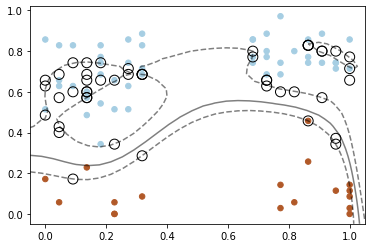

In [11]:
# SVM example
df = pd.read_csv("geyser.csv", sep=',')
X_train, X_test, y_train, y_test = prepare_data(df)
y_pred, y_test = train_svm(X_train, X_test, y_train, y_test, 'rbf')

Best parameters {'C': 10, 'gamma': 1, 'kernel': 'linear'}
F1-score 0.9026592095928482


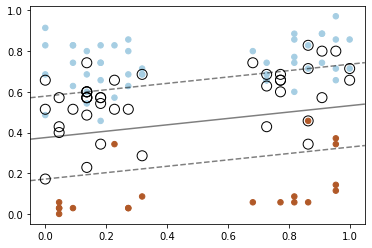

Best parameters {'C': 100, 'gamma': 1, 'kernel': 'poly'}
F1-score 0.8905091598775808


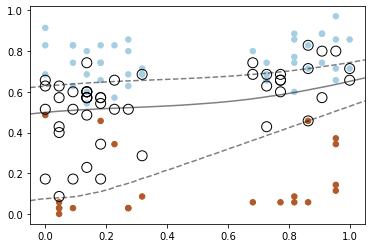

Best parameters {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
F1-score 0.9026592095928482


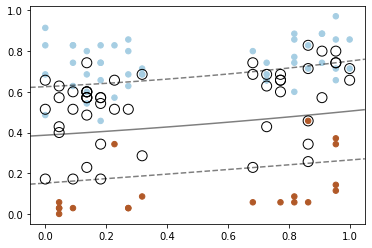

Best parameters {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
F1-score 0.9026592095928482


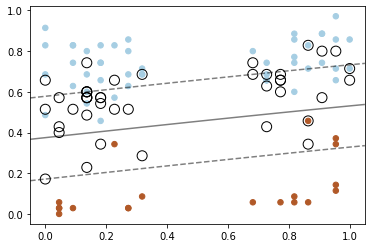

In [94]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

df = pd.read_csv("geyser.csv", sep=',')
X_train, X_test, y_train, y_test = prepare_data(df)

for kernel in kernels:
    grid_params = parameters
    grid_params['kernel'] = [kernel]

    gridsearch = GridSearchCV(SVC(), grid_params, return_train_score=True, scoring=make_scorer(f1_score, average='macro'))
    gridsearch.fit(X_train, y_train.astype('int'))
    
    print(f"Best parameters {gridsearch.best_params_}")

    y_pred = gridsearch.predict(X_test)
    print(f'F1-score {gridsearch.best_score_}')
    plot_hyperplane(gridsearch, X_test, y_pred, True)


Best parameters {'C': 100, 'gamma': 1, 'kernel': 'linear'}
F1-score 0.46747152194211006


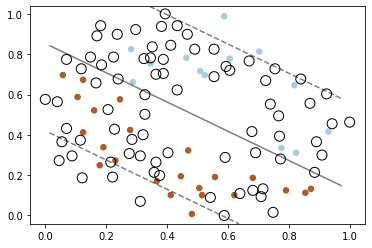

Best parameters {'C': 10, 'gamma': 1, 'kernel': 'poly'}
F1-score 0.6680742296918767


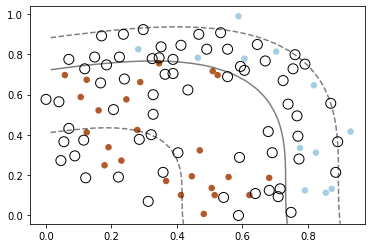

Best parameters {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
F1-score 0.8537939210772029


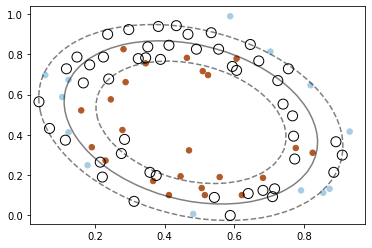

Best parameters {'C': 1000, 'gamma': 0.1, 'kernel': 'sigmoid'}
F1-score 0.4916836379994275


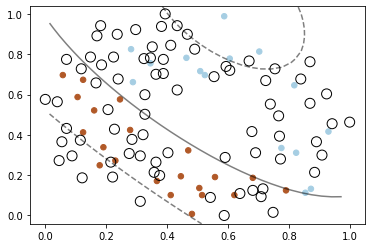

In [93]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

df = pd.read_csv("chips.csv", sep=',')
X_train, X_test, y_train, y_test = prepare_data(df)

for kernel in kernels:
    grid_params = parameters
    grid_params['kernel'] = [kernel]

    gridsearch = GridSearchCV(SVC(), grid_params, return_train_score=True, scoring=make_scorer(f1_score, average='macro'))
    gridsearch.fit(X_train, y_train.astype('int'))
    
    print(f"Best parameters {gridsearch.best_params_}")

    y_pred = gridsearch.predict(X_test)
    print(f'F1-score {gridsearch.best_score_}')
    plot_hyperplane(gridsearch, X_test, y_pred, True)